In [ ]:
"""
%pip install qiskit==2.1.2
%pip install qiskit-ibm-runtime==0.41.1
%pip install qiskit-aer==0.17.2
%pip install pylatexenc
"""

'\n%pip install qiskit==2.1.2\n%pip install qiskit-ibm-runtime==0.41.1\n%pip install qiskit-aer==0.17.2\n%pip install pylatexenc\n'

In [ ]:
from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from math import pi

#Overview

In this Jupyter notebook, we will attempt to implement the 3-qubit error correction code. We will start with the generic |ψ⟩ state, which has a 25% chance of collapsing to |𝟢⟩ and a 75% chance of collapsing to |𝟣⟩. To achieve this quantum state, we will apply a Ry rotation matrix of 𝟤×π/𝟥 degrees; this should be enough to achieve the ratio. We will also create a noisy simulator using Qiskit-Aer. To simulate errors, we apply an adjustable error probability to a set of gates. To test the effectiveness of the 3-qubit error correction code, we will conduct the experiment in two types of circuits: one with error detection only and another with both error detection and correction. We expect, at the end of the experiment, that the 3-qubit error correction code will show advantages.

# 1°: Create the Noisy Model

In the two code cells below, we create a noisy model for the simulations. To implement this, we use Qiskit Aer with an adjustable probability of an error occurring in any of the selected gates. Given that the 3-qubit error correction code requires 1 qubit to represent the state we want to work with, plus two redundancy qubits and 2 ancilla qubits for syndrome detection, we also create all of these in the quantum registers.

In [ ]:
noise_model = NoiseModel()
p_error_1q = 0.2
noisy_gates = ['id','rx', 'ry', 'rz', 'sx', 'x', 'h']
error_1q = depolarizing_error(p_error_1q, 1)
noise_model.add_quantum_error(error_1q,  noisy_gates, [0])
noise_model.add_quantum_error(error_1q, noisy_gates, [1])
noise_model.add_quantum_error(error_1q, noisy_gates, [2])

In [ ]:
q_data = QuantumRegister(3, name='q')
q_syn = QuantumRegister(2, name='syn')
c_data = ClassicalRegister(3, name='c_data')
c_syn = ClassicalRegister(2, name='c_syn')

# 2°: Create the Circuit Without Error Correction Code (Error Detection Only)


In this section, as mentioned previously, we create a state with a 25% chance of collapsing to |𝟢⟩ and a 75% chance of collapsing to |𝟣⟩. However, this circuit represents a control version, containing only error detection and no correction. To create this circuit, we perform the encoder step with entanglement, apply a sequence of identity gates to generate errors, and then go through the syndrome extraction step with the ancilla qubits. Finally, we apply measurements to the logical qubits to analyze the results later.

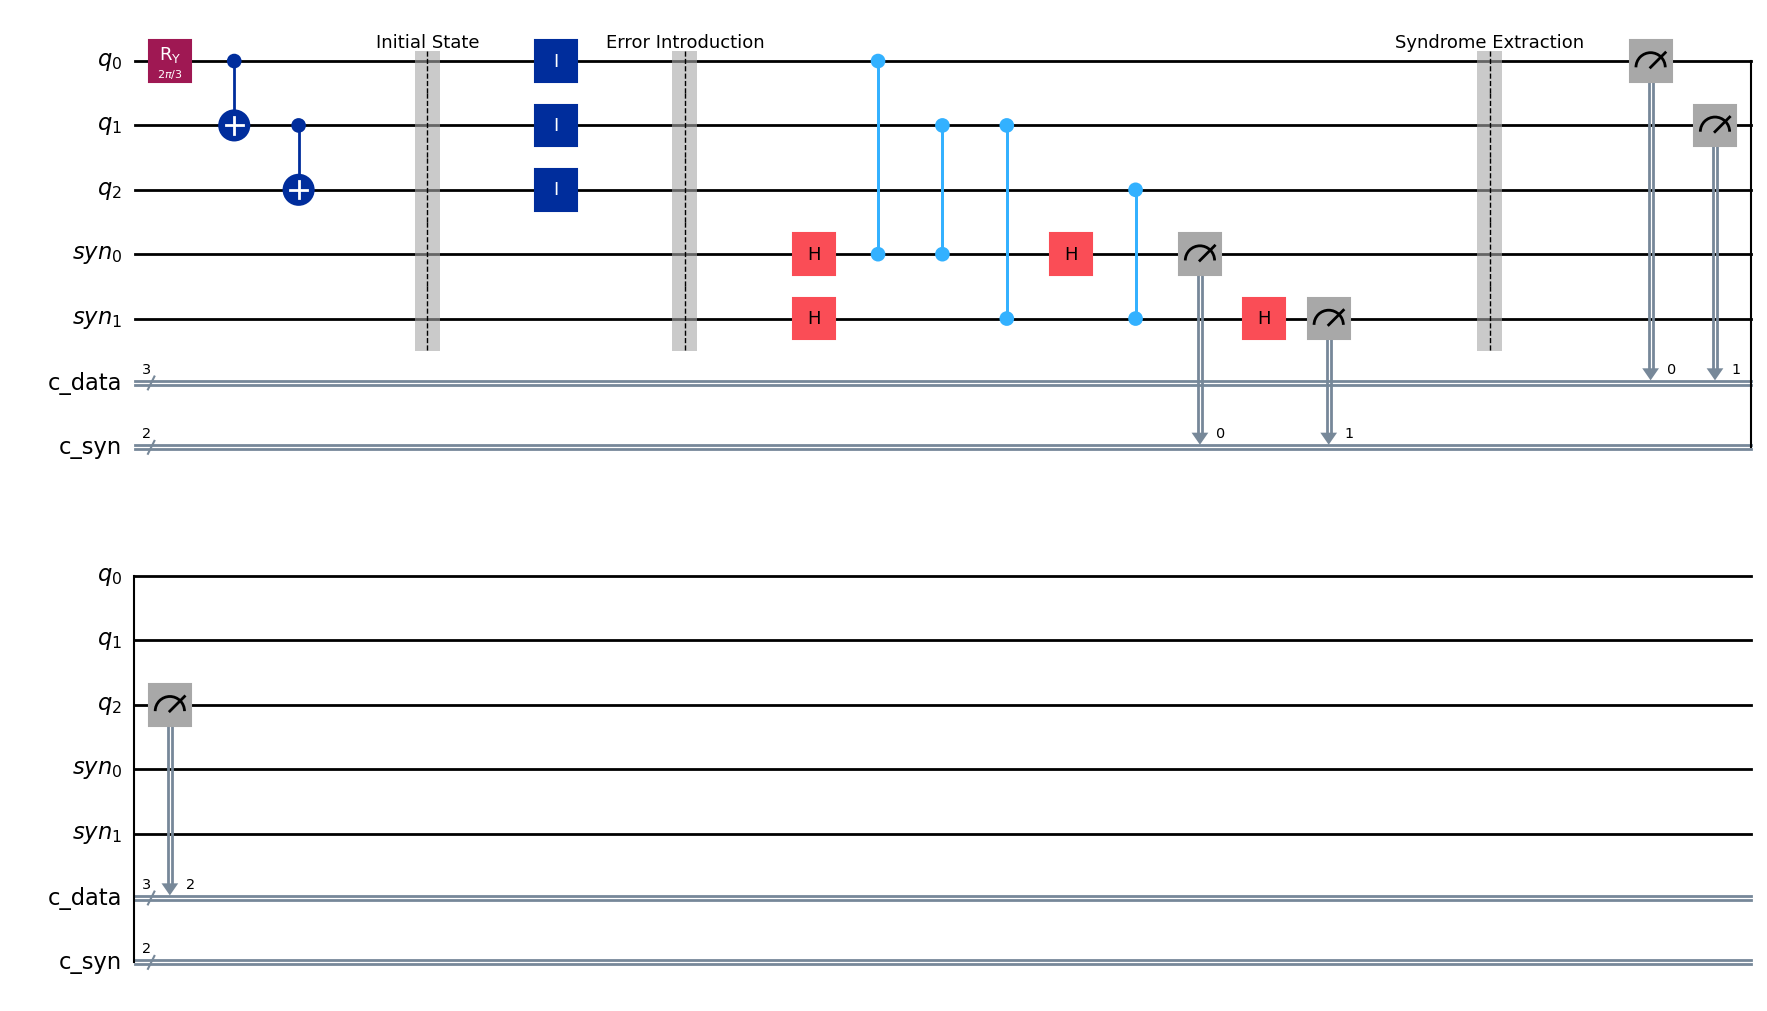

In [ ]:
without_ecc_circuit = QuantumCircuit(q_data, q_syn, c_data, c_syn)

# Initial State
without_ecc_circuit.ry(2*pi/3,q_data[0])
without_ecc_circuit.cx(q_data[0], q_data[1])
without_ecc_circuit.cx(q_data[1], q_data[2])
without_ecc_circuit.barrier(label="Initial State")

# Error Introduction
without_ecc_circuit.id(q_data[:])
without_ecc_circuit.barrier(label="Error Introduction")

# Syndrome Extraction
without_ecc_circuit.h(q_syn[:])
without_ecc_circuit.cz(q_syn[0], q_data[0])
without_ecc_circuit.cz(q_syn[0], q_data[1])
without_ecc_circuit.cz(q_syn[1], q_data[1])
without_ecc_circuit.cz(q_syn[1], q_data[2])
without_ecc_circuit.h(q_syn[:])

without_ecc_circuit.measure(q_syn[0], c_syn[0])
without_ecc_circuit.measure(q_syn[1], c_syn[1])
without_ecc_circuit.barrier(label="Syndrome Extraction")

# Logic Qubit Measurement
without_ecc_circuit.measure(q_data[0], c_data[0])
without_ecc_circuit.measure(q_data[1], c_data[1])
without_ecc_circuit.measure(q_data[2], c_data[2])


without_ecc_circuit.draw('mpl')

# 3°: Create the Circuit With Error Correction Code


In this section, we actually implement the error-corrected circuit. We follow the same procedures as the error-detected circuit. However, we add a further step: given a combination of the results obtained from the ancilla qubits, we obtain an error interpretation. This error interpretation is used with conditional blocks to perform bit-flip correction.

Given that the code distance is 3, our ECC is capable of detecting and correcting up to 1 bit-flip. If two errors occur, the code may incorrectly correct to a different bitstring than was actually intended. However, this should not generate errors beyond the proportion of valid states (codespace). With ECC, quantum states belonging to the error space should be mitigated as much as possible (or eliminated).

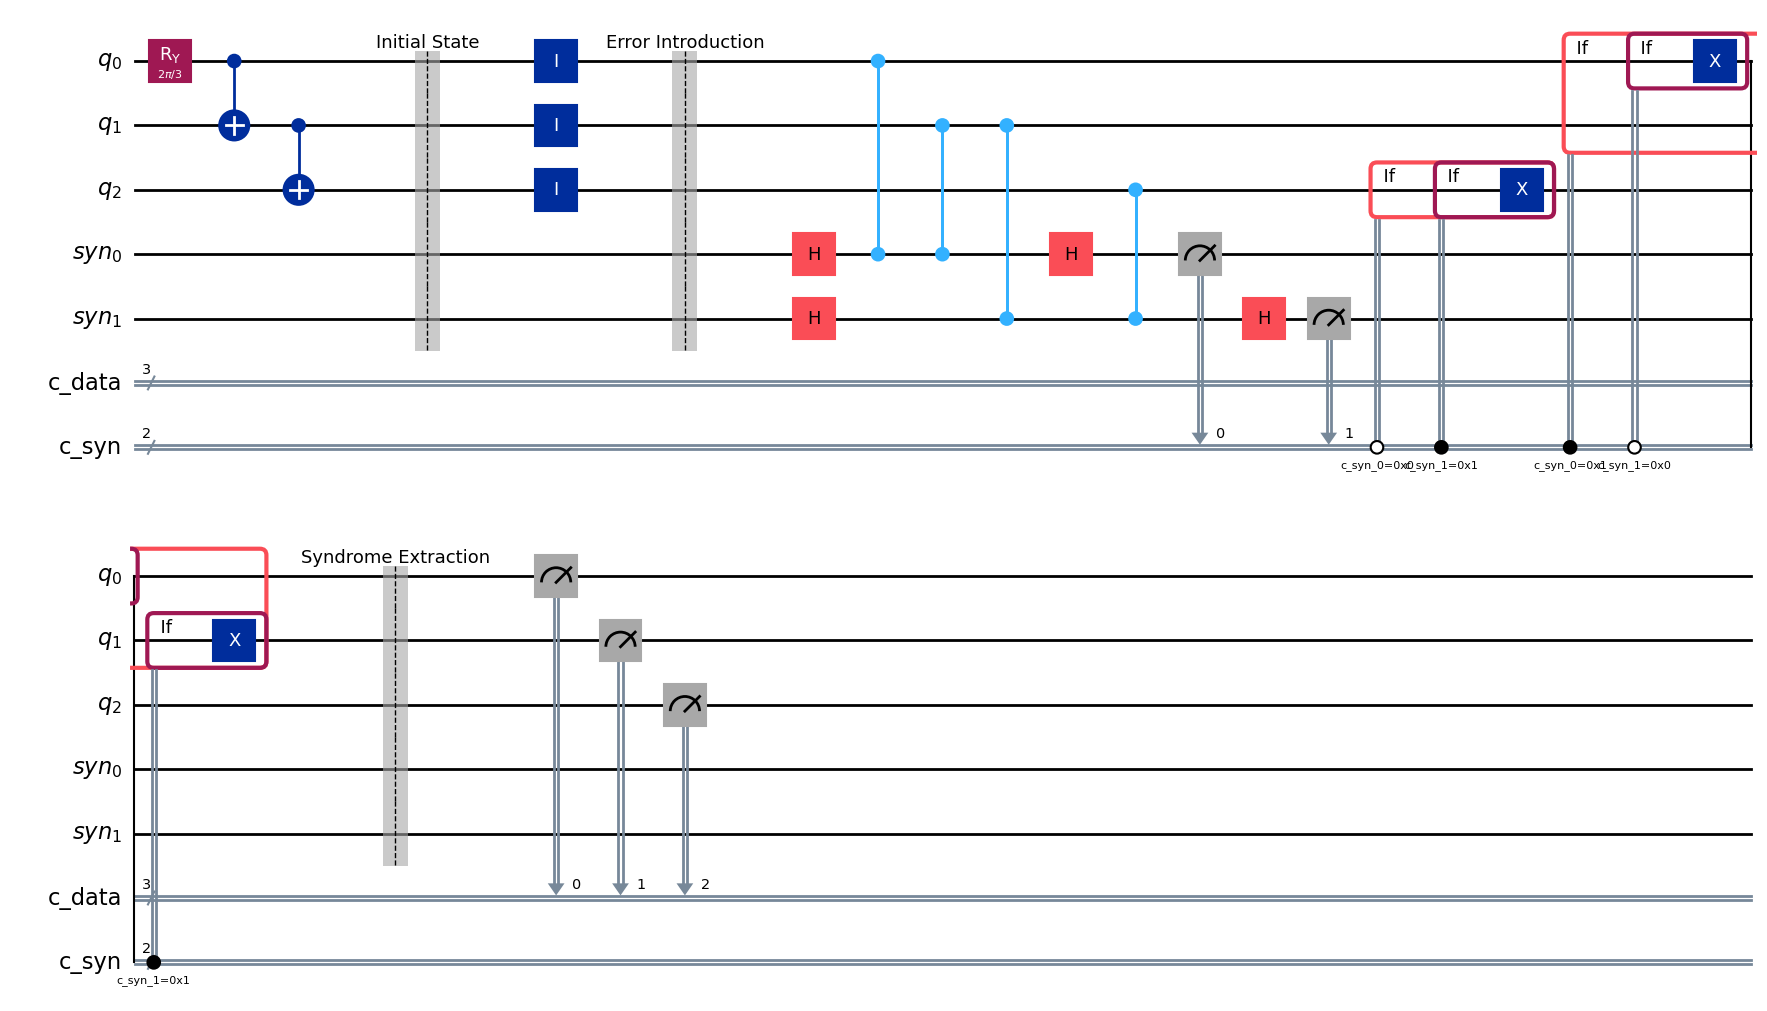

In [ ]:
ecc_circuit = QuantumCircuit(q_data, q_syn, c_data, c_syn)

# Initial State
ecc_circuit.ry(2*pi/3,q_data[0])
ecc_circuit.cx(q_data[0], q_data[1])
ecc_circuit.cx(q_data[1], q_data[2])
ecc_circuit.barrier(label="Initial State")

# Error Introduction
ecc_circuit.id(q_data[:])
ecc_circuit.barrier(label="Error Introduction")

# Syndrome Extraction
ecc_circuit.h(q_syn[:])
ecc_circuit.cz(q_syn[0], q_data[0])
ecc_circuit.cz(q_syn[0], q_data[1])
ecc_circuit.cz(q_syn[1], q_data[1])
ecc_circuit.cz(q_syn[1], q_data[2])
ecc_circuit.h(q_syn[:])

ecc_circuit.measure(q_syn[0], c_syn[0])
ecc_circuit.measure(q_syn[1], c_syn[1])

# Error Correction Sub Routine
with ecc_circuit.if_test((c_syn[0], 0)):
  with ecc_circuit.if_test((c_syn[1], 1)):
    ecc_circuit.x(q_data[2])

with ecc_circuit.if_test((c_syn[0], 1)):

  with ecc_circuit.if_test((c_syn[1], 0)):
    ecc_circuit.x(q_data[0])

  with ecc_circuit.if_test((c_syn[1], 1)):
    ecc_circuit.x(q_data[1])
ecc_circuit.barrier(label="Syndrome Extraction")

# Logic Qubit Measurement
ecc_circuit.measure(q_data[0], c_data[0])
ecc_circuit.measure(q_data[1], c_data[1])
ecc_circuit.measure(q_data[2], c_data[2])


ecc_circuit.draw('mpl')

# 4°: Results View

Finally, in this section, we analyze the results obtained in the simulations with and without ECC. Our data analysis allows us to infer that error-correcting codes allow a significant increase in corrections back to the codespace. The quantum states belonging to the error space were also significantly reduced in the scenario where ECC was used.

Of course, the probability of gate application errors also has a significant impact on the simulations. If they increase, the ECC success rate decreases. To overcome this problem, chip engineering must be improved or, in the worst-case scenario, we can increase qubit redundancy to create logical information, sacrificing the number of available qubits.

In [ ]:
sim_noise = AerSimulator(noise_model=noise_model)
shots = 1024
without_ecc_job = sim_noise.run(without_ecc_circuit, shots=shots)
ecc_job = sim_noise.run(ecc_circuit, shots=shots)

without_ecc_count = without_ecc_job.result().get_counts()
ecc_count = ecc_job.result().get_counts()

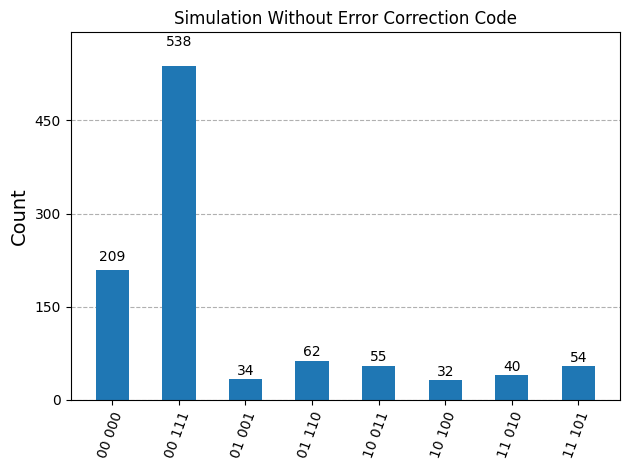

In [ ]:
plot_histogram(title='Simulation Without Error Correction Code',data=without_ecc_count)

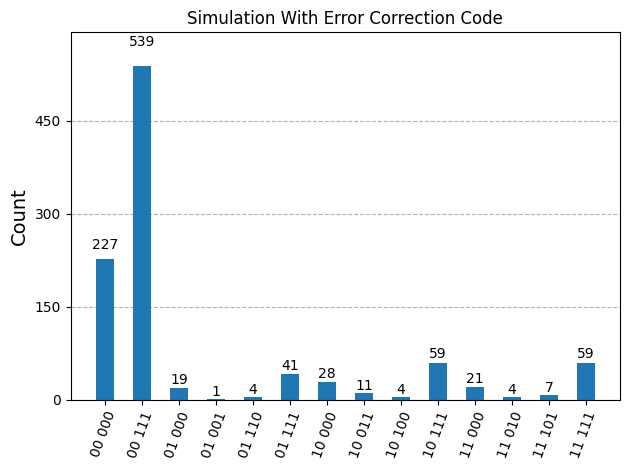

In [ ]:
plot_histogram(title='Simulation With Error Correction Code',data=ecc_count)

In [ ]:
without_ecc_hit_rate = 0
ecc_hit_rate = 0

for bitstring, count in without_ecc_count.items():
  if bitstring.endswith('000') or bitstring.endswith('111'):
    without_ecc_hit_rate += count

for bitstring, count in ecc_count.items():
  if bitstring.endswith('000') or bitstring.endswith('111'):
    ecc_hit_rate += count

In [ ]:
new_without_ecc_count = {}
new_ecc_count = {}

for bitstring, count in without_ecc_count.items():
  bits = bitstring[-3:]
  new_without_ecc_count[bits] = new_without_ecc_count.get(bits, 0) + count


for bitstring, count in ecc_count.items():
  bits = bitstring[-3:]
  new_ecc_count[bits] = new_ecc_count.get(bits, 0) + count

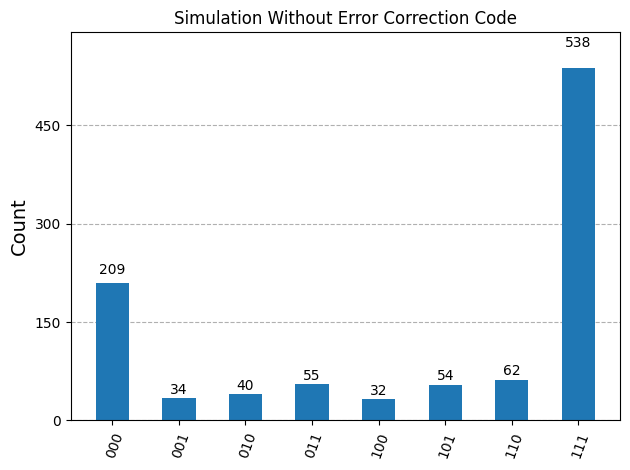

In [ ]:
plot_histogram(title='Simulation Without Error Correction Code',data=new_without_ecc_count)

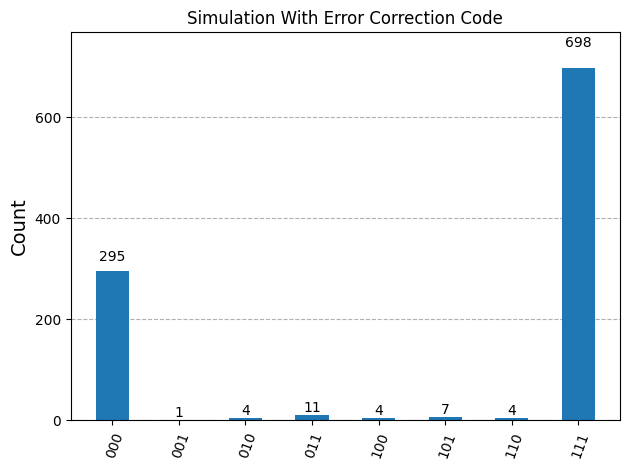

In [ ]:
plot_histogram(title='Simulation With Error Correction Code',data=new_ecc_count)

In [ ]:
without_ecc_hit_rate = without_ecc_hit_rate*100/1024
ecc_hit_rate = ecc_hit_rate*100/1024

print("General Data of The Experiment: ")
print(f"Without ECC Hit Rate: {without_ecc_hit_rate:.2f}%")
print(f"With ECC Hit Rate: {ecc_hit_rate:.2f}%")

General Data of The Experiment: 
Without ECC Hit Rate: 72.95%
With ECC Hit Rate: 96.97%
